In [1]:
%load_ext dotenv
%dotenv -o

import os
os.environ["POLYGON_DATA_DIR"]

'/media/mirror/files.polygon.io'

In [142]:
from zipline_polygon_bundle.config import PolygonConfig
from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
from zipline_polygon_bundle import get_custom_aggs_dates

from typing import Iterator, Tuple

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import compute as pc
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [3]:
if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/data"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2018-01-01",
    end_date="2023-12-31",
    agg_time="1min",
)

pd.set_option('display.width', 250)

print(f"{config.minute_aggs_dir=}")
print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
print(f"{config.aggs_dir=}")
print(f"{config.by_ticker_dir=}")

config.minute_aggs_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/minute_aggs_v1'
config.trades_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/trades_v1'
config.custom_aggs_dir='/home/jovyan/data/60sec_aggs'
config.aggs_dir='/home/jovyan/data/60sec_aggs'
config.by_ticker_dir='/home/jovyan/data/60sec_aggs_by_ticker'


In [6]:
aggs_ds = pa_ds.dataset(config.custom_aggs_dir, format="parquet", schema=custom_aggs_schema(), partitioning=custom_aggs_partitioning())
# aggs_ds = pa_ds.dataset(config.custom_aggs_dir, format="parquet", partitioning=custom_aggs_partitioning())
aggs_ds

In [7]:
aggs_ds.partition_expression

<pyarrow.compute.Expression true>

In [8]:
pa_ds.get_partition_keys(aggs_ds.partition_expression)

{}

In [ ]:
for fragment in aggs_ds.get_fragments():
    print(f"{fragment.partition_expression=}")
    print(f"{pa_ds.get_partition_keys(fragment.partition_expression)=}")
    # print(f"{fragment.partition_expression.get_partition_values()=}")
    # print(f"{fragment.physical_schema=}")


In [ ]:
set([pa_ds.get_partition_keys(fragment.partition_expression).get("date") for fragment in aggs_ds.get_fragments()])

In [11]:
for fragment in aggs_ds.get_fragments():
    if pa_ds.get_partition_keys(fragment.partition_expression).get("date") is None:
        print(f"{fragment=}")

In [ ]:
get_custom_aggs_dates(config)

In [ ]:
set([(date.year, date.month) if date else None for date in get_custom_aggs_dates(config)])

In [ ]:
set([(date.year, date.month) for date in get_custom_aggs_dates(config)])

In [ ]:
for fragment in aggs_ds.get_fragments():
    print(f"{fragment.partition_expression=}")
    print(f"{pa_ds.get_partition_keys(fragment.partition_expression)=}")
    # print(f"{fragment.physical_schema=}")
    table = fragment.to_table()
    # print(f"{table.slice(length=1)=}")
    # print(f"{table.schema=}")
    # print(f"{table=}")
    df = table.to_pandas()
    df['window_start'] = df['window_start'].dt.tz_convert('EST')
    df.info()
    print(f"{df['window_start'].min()=}")
    print(f"{df['window_start'].max()=}")
    print(df)
    print()

In [8]:
fragments = aggs_ds.get_fragments()
fragment = next(fragments)
table = fragment.to_table()
aggs_df = table.to_pandas()
aggs_df

,ticker,window_start,open,high,low,close,volume,transactions
0,CRMT,2018-01-02 20:09:00+00:00,44.025,44.025,44.025,44.025,100,1
1,CRR,2018-01-02 20:09:00+00:00,10.490,10.490,10.490,10.490,1060,10
2,CRSP,2018-01-02 20:09:00+00:00,24.800,24.830,24.800,24.830,130,2
3,CRTO,2018-01-02 20:09:00+00:00,26.200,26.200,26.190,26.190,300,4
4,CRUS,2018-01-02 20:09:00+00:00,53.110,53.120,53.110,53.120,825,11
...,...,...,...,...,...,...,...,...
1274239,DKL,2018-01-02 16:31:00+00:00,32.200,32.200,32.200,32.200,100,1
1274240,DKS,2018-01-02 16:31:00+00:00,29.380,29.420,29.375,29.410,7675,75
1274241,DLB,2018-01-02 16:31:00+00:00,62.730,62.730,62.730,62.730,10,1
1274242,DLHC,2018-01-02 16:31:00+00:00,6.160,6.160,6.160,6.160,289,4


In [9]:
table = pa_parquet.read_table('/home/jovyan/data/60sec_aggs/year=2022/month=3/date=2022-03-18/part-0.parquet')
table

pyarrow.Table
ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
volume: int64
transactions: int64
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>
----
ticker: [["KBA","KBAL","KBE","KBH","KBND",...,"CNTB","COF","COIN","COMT","CPNG"],["BGR","BGRY","BGS","BGY","BH",...,"TRIP","TRMB","TRMK","TRMR","TRN"],...,["MXL","MYE","MYFW","MYGN","MYI",...,"KAPR","KAR","KARS","KAVL","KB"],["VERU","VERV","VERX","VET","VEU",...,"BROS","BRP","BRQS","BRSP","BRT"]]
window_start: [[2022-03-18 19:59:00.000000000Z,2022-03-18 19:59:00.000000000Z,2022-03-18 19:59:00.000000000Z,2022-03-18 19:59:00.000000000Z,2022-03-18 19:59:00.000000000Z,...,2022-03-18 20:25:00.000000000Z,2022-03-18 20:25:00.000000000Z,2022-03-18 20:25:00.000000000Z,2022-03-18 20:25:00.000000000Z,2022-03-18 20:25:00.000000000Z],[2022-03-18 13:39:00.000000000Z,2

In [41]:
aggs_df = table.to_pandas()
# aggs_df['window_start'] = aggs_df['window_start'].dt.tz_convert('US/Eastern')
aggs_df.set_index(['ticker', 'window_start'], inplace=True)
aggs_df.sort_index(inplace=True)
aggs_df

open    high     low    close  volume  transactions  year month        date
ticker window_start                                                                                             
A      2022-03-18 11:15:00+00:00  136.800  136.80  136.80  136.800       5             1  2022     3  2022-03-18
       2022-03-18 12:25:00+00:00  136.050  137.24  136.05  136.300      35             6  2022     3  2022-03-18
       2022-03-18 12:34:00+00:00  136.300  136.82  136.30  136.820       2             2  2022     3  2022-03-18
       2022-03-18 13:28:00+00:00  136.110  136.11  136.11  136.110       1             1  2022     3  2022-03-18
       2022-03-18 13:29:00+00:00  136.110  136.11  135.79  135.790     150             5  2022     3  2022-03-18
...                                   ...     ...     ...      ...     ...           ...   ...   ...         ...
ZYXI   2022-03-18 19:57:00+00:00    5.790    5.80    5.78    5.790    3515            60  2022     3  2022-03-18
       2022-03-18 19:58:00+00:00    5.785    5.79    5.78    5.785    1702            37  2022     3  2022-03-18
       2022-03-18 19:59:00+00:00    5.780    5.79    5.77    5.790    6336            89  2022     3  2022-03-18
       2022-03-18 20:00:00+00:00    5.780    5.79    5.78    5.780  294401             4  2022     3  2022-03-18
       2022-03-18 23:52:00+00:00    5.800    5.80    5.80    5.800     232             1  2022     3  2022-03-18

[1926384 rows x 9 columns]

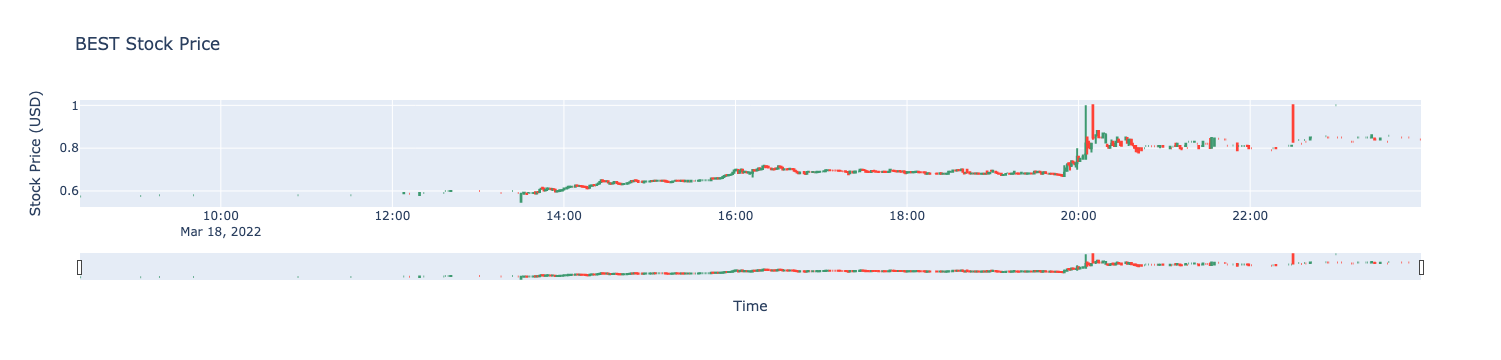

In [42]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [ ]:
# This was run including the TRF trades.  The notable difference is ignoring the the $1.0 trade reported at 21:05 but which took place earlier. The bars at 20:05, 20:10, and 22:30 seem related.
# https://polygon.io/blog/understanding-trade-eligibility

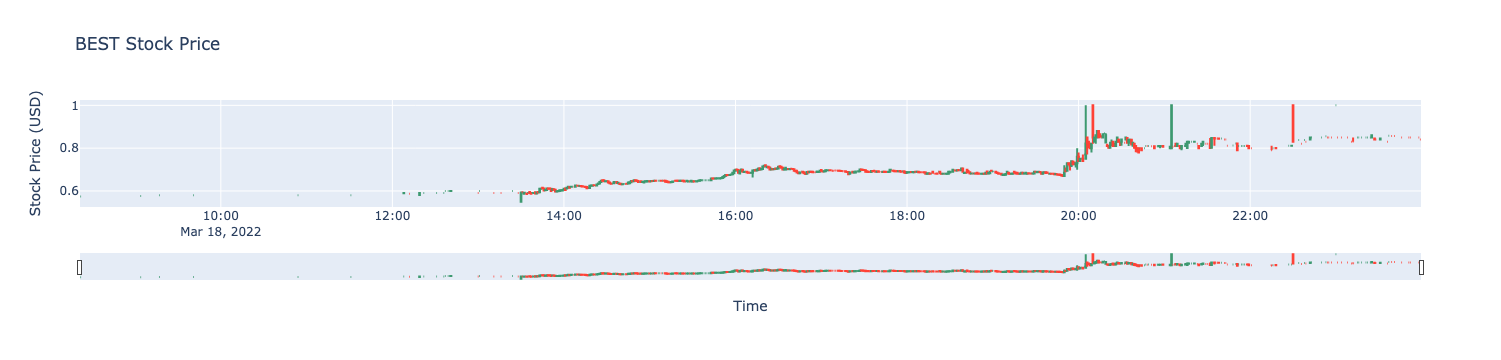

In [39]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [6]:
table_gen = generate_csv_trades_tables(config)

In [7]:
date, trades_table = next(table_gen)
date, trades_table

(datetime.date(2021, 1, 4),
 pyarrow.Table
 ticker: string not null
 conditions: string not null
 correction: string not null
 exchange: int8 not null
 id: string not null
 participant_timestamp: timestamp[ns, tz=UTC] not null
 price: double not null
 sequence_number: int64 not null
 sip_timestamp: timestamp[ns, tz=UTC] not null
 size: int64 not null
 tape: int8 not null
 trf_id: int64 not null
 trf_timestamp: timestamp[ns, tz=UTC] not null
 ----
 ticker: [["A","A","A","A","A",...,"A","A","A","A","A"],["A","A","A","A","A",...,"AA","AA","AA","AA","AA"],...,["ZVO","ZVO","ZVO","ZVO","ZVO",...,"ZYNE","ZYNE","ZYNE","ZYNE","ZYNE"],["ZYNE","ZYNE","ZYNE","ZYNE","ZYNE",...,"ZYXI","ZYXI","ZYXI","ZYXI","ZYXI"]]
 conditions: [["12,37","12,37","12,37","12,37","12,37",...,"37","14,41","14,37,41","14,41","14,37,41"],["14,37,41","14,37,41","14,37,41","14,37,41","14,41",...,"","","14,41","14,41","14,37,41"],...,["37","37","","","37",...,"37","37","37","14,37,41","37"],["","37","37","37","37",...,"12,37

In [8]:
aggs_table = trades_to_custom_aggs(config, date, trades_table)
aggs_table

date=datetime.date(2021, 1, 4) pa.total_allocated_bytes()=6924336192
mp.backend_name='mimalloc' mp=<pyarrow.MemoryPool backend_name=mimalloc bytes_allocated=6924336192 max_memory=6931781696>
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss=7806996


pyarrow.Table
ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
size_sum: int64
transactions: int64
----
ticker: [["CTEST.A","MTEST.A","PTEST.A","ATEST.A","CTEST.A",...,"ZOM","ZROZ","ZSL","ZTEST","ZTST"]]
window_start: [[2021-01-04 06:30:00.000000000Z,2021-01-04 06:30:00.000000000Z,2021-01-04 06:30:00.000000000Z,2021-01-04 06:31:00.000000000Z,2021-01-04 06:31:00.000000000Z,...,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z]]
open: [[10.604894,14.720926,10.593358,12.645032,14.515077,...,0.35,162.67,6.41,10.1,40.17]]
high: [[11.510764,14.720926,12.273018,14.552261,14.515077,...,0.35,162.67,6.41,10.1,40.17]]
low: [[10.604894,14.720926,10.593358,10.854299,11.478276,...,0.35,162.67,6.41,10.1,40.17]]
close: [[11.510764,14.720926,12.273018,10.854299,11.556036,...,0.35,162.67,6.41,10.1,40.17]]
size_sum: [[222,111,222,666,444,.

In [10]:
aggs_df = aggs_table.slice(length=1000).to_pandas()
show(aggs_df)

In [10]:
len(trades_table)

76084591

In [12]:
tt = trades_table.append_column('foo', pa.array([123] * len(trades_table)))
tt

pyarrow.Table
ticker: string not null
conditions: string not null
correction: string not null
exchange: int8 not null
id: string not null
participant_timestamp: timestamp[ns, tz=UTC] not null
price: double not null
sequence_number: int64 not null
sip_timestamp: timestamp[ns, tz=UTC] not null
size: int64 not null
tape: int8 not null
trf_id: int64 not null
trf_timestamp: timestamp[ns, tz=UTC] not null
foo: int64
----
ticker: [["A","A","A","A","A",...,"A","A","A","A","A"],["A","A","A","A","A",...,"AA","AA","AA","AA","AA"],...,["ZVO","ZVO","ZVO","ZVO","ZVO",...,"ZYNE","ZYNE","ZYNE","ZYNE","ZYNE"],["ZYNE","ZYNE","ZYNE","ZYNE","ZYNE",...,"ZYXI","ZYXI","ZYXI","ZYXI","ZYXI"]]
conditions: [["12,37","12,37","12,37","12,37","12,37",...,"37","14,41","14,37,41","14,41","14,37,41"],["14,37,41","14,37,41","14,37,41","14,37,41","14,41",...,"","","14,41","14,41","14,37,41"],...,["37","37","","","37",...,"37","37","37","14,37,41","37"],["","37","37","37","37",...,"12,37","12,37","12,37","12,37","12,37"]

In [10]:
len(table)

1926384

In [11]:
table.schema

ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
volume: int64
transactions: int64
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>

In [ ]:
table['window_start']

In [15]:
table = table.combine_chunks()
table.schema

ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
volume: int64
transactions: int64
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>

In [18]:
table['window_start']

[
  [
    2022-03-18 19:59:00.000000000Z,
    2022-03-18 19:59:00.000000000Z,
    2022-03-18 19:59:00.000000000Z,
    2022-03-18 19:59:00.000000000Z,
    2022-03-18 19:59:00.000000000Z,
    ...
    2022-03-18 19:37:00.000000000Z,
    2022-03-18 19:37:00.000000000Z,
    2022-03-18 19:37:00.000000000Z,
    2022-03-18 19:37:00.000000000Z,
    2022-03-18 19:37:00.000000000Z
  ]
]

In [19]:
len(table['window_start'])

1926384

In [20]:
trades_df = table.to_pandas()
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926384 entries, 0 to 1926383
Data columns (total 11 columns):
 #   Column        Dtype              
---  ------        -----              
 0   ticker        object             
 1   window_start  datetime64[ns, UTC]
 2   open          float64            
 3   high          float64            
 4   low           float64            
 5   close         float64            
 6   volume        int64              
 7   transactions  int64              
 8   year          category           
 9   month         category           
 10  date          category           
dtypes: category(3), datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 123.1+ MB


In [25]:
trades_df.set_index(['ticker', 'window_start'], inplace=True)
trades_df.sort_index(inplace=True)

In [ ]:
show(trades_df.head(10))

In [ ]:
gains_df = trades_df.groupby(level=0).apply(lambda df: df.rolling(window=pd.Timedelta(hours=1)).min())

In [42]:
gains_df = trades_df.groupby(level=0).rolling(window=10).low.min()
gains_df.info()
gains_df

<class 'pandas.core.series.Series'>
MultiIndex: 1926384 entries, ('A', 'A', Timestamp('2022-03-18 11:15:00+0000', tz='UTC')) to ('ZYXI', 'ZYXI', Timestamp('2022-03-18 23:52:00+0000', tz='UTC'))
Series name: low
Non-Null Count    Dtype  
--------------    -----  
1832500 non-null  float64
dtypes: float64(1)
memory usage: 26.2+ MB


ticker  ticker  window_start             
A       A       2022-03-18 11:15:00+00:00     NaN
                2022-03-18 12:25:00+00:00     NaN
                2022-03-18 12:34:00+00:00     NaN
                2022-03-18 13:28:00+00:00     NaN
                2022-03-18 13:29:00+00:00     NaN
                                             ... 
ZYXI    ZYXI    2022-03-18 19:57:00+00:00    5.78
                2022-03-18 19:58:00+00:00    5.78
                2022-03-18 19:59:00+00:00    5.77
                2022-03-18 20:00:00+00:00    5.77
                2022-03-18 23:52:00+00:00    5.77
Name: low, Length: 1926384, dtype: float64

In [ ]:
show(gains_df.head(1000))

In [43]:
aapl_df=trades_df.loc['AAPL']
aapl_df.info()
aapl_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 959 entries, 2022-03-18 08:00:00+00:00 to 2022-03-18 23:59:00+00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   open          959 non-null    float64 
 1   high          959 non-null    float64 
 2   low           959 non-null    float64 
 3   close         959 non-null    float64 
 4   volume        959 non-null    int64   
 5   transactions  959 non-null    int64   
 6   year          959 non-null    category
 7   month         959 non-null    category
 8   date          959 non-null    category
dtypes: category(3), float64(4), int64(2)
memory usage: 55.6 KB


,open,high,low,close,volume,transactions,year,month,date
window_start,,,,,,,,,
2022-03-18 08:00:00+00:00,159.77,159.95,159.50,159.77,1203,58,2022,3,2022-03-18
2022-03-18 08:01:00+00:00,159.77,159.89,159.64,159.89,897,41,2022,3,2022-03-18
2022-03-18 08:02:00+00:00,159.81,159.88,159.57,159.79,667,28,2022,3,2022-03-18
2022-03-18 08:03:00+00:00,159.70,159.81,159.69,159.75,253,18,2022,3,2022-03-18
2022-03-18 08:04:00+00:00,159.67,159.80,159.67,159.78,866,30,2022,3,2022-03-18
...,...,...,...,...,...,...,...,...,...
2022-03-18 23:55:00+00:00,164.25,164.25,164.16,164.25,370,8,2022,3,2022-03-18
2022-03-18 23:56:00+00:00,164.25,164.25,164.20,164.25,7346,19,2022,3,2022-03-18
2022-03-18 23:57:00+00:00,164.26,164.28,164.23,164.24,840,14,2022,3,2022-03-18


In [52]:
show(aapl_df.rolling('1h').agg(close_min=('close', 'min'), close_max=('close', 'max'), close_first=('close', 'first'), close_last=('close', 'last')))

TypeError: Rolling.aggregate() missing 1 required positional argument: 'func'

In [ ]:
show(aapl_df.rolling('1h').close.min())

In [ ]:
show(aapl_df.rolling('1h').volume.sum())

In [ ]:
df = trades_df.copy()

# Assuming 'df' is your DataFrame with a MultiIndex (ticker, timestamp) and OHLCV columns
# Create a new column for the next timestamp with a lower close price
df['next_lower_close_timestamp'] = pd.NaT

# Iterate through each group of tickers
for ticker, group in df.groupby(level='ticker'):
    # Iterate through each row in the group
    for i in range(len(group)):
        current_close = group.iloc[i]['close']
        current_timestamp = group.index[i][1]
        
        # Find the next row with a lower close price
        next_lower_close = group.iloc[i+1:][group['close'] < current_close]
        
        if not next_lower_close.empty:
            next_timestamp = next_lower_close.index[0][1]
            df.loc[(ticker, current_timestamp), 'next_lower_close_timestamp'] = next_timestamp

df

In [39]:
df = trades_df.copy()
def fillem(df):
    df.index = df.index.get_level_values(1)
    df = df.resample('1min')
    df['volume'] = df['volume'].fillna(0)
    return df.ffill()
df.groupby(level='ticker').apply(fillem)

NameError: name 'trades_df' is not defined

In [99]:
a_df = trades_df.loc['AAPL'].copy()
a_df = a_df.asfreq('1min')
a_df['volume'] = a_df['volume'].fillna(0)
a_df['close'] = a_df['close'].ffill()
a_df['fwd_1h_min_close'] = a_df.rolling('1h').close.min()
a_df['fwd_1h_max_close'] = a_df.rolling('1h').close.max()
a_df['gain_1h'] = ((a_df['fwd_1h_max_close'] - a_df['close']) / a_df['close']) * 100
a_df['loss_1h'] = ((a_df['fwd_1h_min_close'] - a_df['close']) / a_df['close']) * 100
show(a_df)

In [2]:
a_df = trades_df.loc['BEST'].copy()
# a_df = a_df.asfreq('1min')
# a_df['volume'] = a_df['volume'].fillna(0)
# a_df['close'] = a_df['close'].ffill()
a_df['fwd_1h_min_close'] = a_df.rolling('1h').close.min()
a_df['fwd_1h_max_close'] = a_df.rolling('1h').close.max()
a_df['gain_1h'] = (a_df['fwd_1h_max_close'] - a_df['close']) / a_df['close']
a_df['loss_1h'] = (a_df['fwd_1h_min_close'] - a_df['close']) / a_df['close']
show(a_df)

NameError: name 'trades_df' is not defined

In [ ]:
df = trades_df.copy()

# Assuming 'df' is your DataFrame with a MultiIndex (ticker, timestamp) and OHLCV columns
# Resample the DataFrame to fill in missing rows for each ticker

df = df.groupby(level='ticker').apply(lambda x: x.reset_index(level=1, drop=True).resample('1m', level='window_start').ffill())

# Create a new column for the next timestamp with a lower close price
df['next_lower_close_timestamp'] = pd.NaT

# Function to find the next lower close price within a rolling window
def find_next_lower_close(group):
    close_prices = group['close']
    timestamps = group.index.get_level_values('window_start')
    
    next_lower_close_timestamps = []
    for i in range(len(close_prices)):
        current_close = close_prices[i]
        future_close_prices = close_prices[i+1:i+61]  # Look ahead 60 minutes
        future_timestamps = timestamps[i+1:i+61]
        
        lower_close_idx = future_close_prices[future_close_prices < current_close].index
        if not lower_close_idx.empty:
            next_lower_close_timestamps.append(future_timestamps[lower_close_idx[0]])
        else:
            next_lower_close_timestamps.append(pd.NaT)
    
    return pd.Series(next_lower_close_timestamps, index=group.index)

# Apply the function to each group of tickers
df['next_lower_close_timestamp'] = df.groupby(level='ticker').apply(find_next_lower_close)

df

In [ ]:
show(aapl_df.rolling('1h').close.max())

In [ ]:
show(aapl_df)

In [4]:
table = pa_parquet.read_table('/home/jovyan/data/60sec_aggs/year=2024/month=12/date=2024-12-05/part-0.parquet')
aggs_df = table.to_pandas()
aggs_df['window_start'] = aggs_df['window_start'].dt.tz_convert('US/Eastern')
aggs_df.set_index(['ticker', 'window_start'], inplace=True)
aggs_df.sort_index(inplace=True)

In [5]:
a_df = aggs_df.loc['RKDA'].copy()
open_price = a_df.iloc[0]['open']
a_df['gain_from_open'] = ((a_df['open'] - open_price) / open_price) * 100
a_df.sort_index(ascending=False, inplace=True)
a_df['fwd_1h_min_low'] = a_df.rolling('1h', closed='left').low.min()
a_df['fwd_1h_max_open'] = a_df.rolling('1h', closed='left').open.max()
# a_df['fwd_4h_min_low'] = a_df.rolling('4h', closed='left').low.min()
# a_df['fwd_4h_max_close'] = a_df.rolling('4h', closed='left').close.max()
a_df.sort_index(ascending=True, inplace=True)
next_close = a_df['close'].shift(-1)
# a_df['next_close'] = next_close
a_df['gain_1h'] = (((a_df['fwd_1h_max_open'] - next_close) / next_close) * 100)
a_df['loss_1h'] = (((a_df['fwd_1h_min_low'] - next_close) / next_close) * 100)
# a_df['gain_4h'] = (((a_df['fwd_4h_max_close'] - a_df['close']) / a_df['close']) * 100)
# a_df['loss_4h'] = (((a_df['fwd_4h_min_low'] - a_df['close']) / a_df['close']) * 100)
# a_df['gain_1h'] = (((a_df['fwd_1h_max_close'] - a_df['close']) / a_df['close']) * 100).shift(periods=1, freq="h")
# a_df['loss_1h'] = (((a_df['fwd_1h_min_low'] - a_df['close']) / a_df['close']) * 100).shift(periods=1, freq="h")
# a_df['gain_4h'] = (((a_df['fwd_4h_max_close'] - a_df['close']) / a_df['close']) * 100).shift(periods=4, freq="h")
# a_df['loss_4h'] = (((a_df['fwd_4h_min_low'] - a_df['close']) / a_df['close']) * 100).shift(periods=4, freq="h")
# a_df.drop(["open", "high", "low"], axis=1, inplace=True)
show(a_df)

In [6]:
show(a_df[(a_df['loss_1h'] > -5) & (a_df['gain_1h'] > 50)])

In [7]:
show(a_df[(a_df['loss_1h'] >= -1) & (a_df['gain_1h'] > 10)])

In [8]:
show(a_df[(a_df['gain_from_open'] >= 10) & (a_df['gain_1h'] > 40)])

In [20]:
# the_date = pd.to_datetime(a_df['date'].unique()[0]).tz_localize('US/Eastern')
the_date = pd.to_datetime(a_df['date'].unique()[0])
the_date

Timestamp('2024-12-05 00:00:00')

In [31]:
calendar = pandas_market_calendars.get_calendar(config.calendar_name)
schedule = calendar.schedule(start_date=the_date, end_date=the_date, start="pre", end="post", tz='US/Eastern')
schedule

,pre,market_open,market_close,post
2024-12-05,2024-12-05 04:00:00-05:00,2024-12-05 09:30:00-05:00,2024-12-05 16:00:00-05:00,2024-12-05 20:00:00-05:00


In [29]:
schedule.iloc[0]['pre']

Timestamp('2024-12-05 04:00:00-0500', tz='US/Eastern')

In [33]:
a_df.loc[schedule.iloc[0]['pre']:schedule.iloc[0]['market_open']]

,open,high,low,close,volume,transactions,year,month,date
window_start,,,,,,,,,
2024-12-05 08:02:00-05:00,2.81,4.09,2.79,3.49,8556,125,2024,12,2024-12-05
2024-12-05 08:03:00-05:00,3.49,4.95,3.29,4.67,104406,1095,2024,12,2024-12-05
2024-12-05 08:04:00-05:00,4.64,6.24,4.64,5.48,264580,3007,2024,12,2024-12-05
2024-12-05 08:05:00-05:00,5.50,5.80,5.01,5.38,175500,2462,2024,12,2024-12-05
2024-12-05 08:06:00-05:00,5.40,5.40,4.74,5.15,161050,1679,2024,12,2024-12-05
...,...,...,...,...,...,...,...,...,...
2024-12-05 09:26:00-05:00,7.61,7.62,7.35,7.35,33790,402,2024,12,2024-12-05
2024-12-05 09:27:00-05:00,7.41,7.46,7.16,7.31,31322,455,2024,12,2024-12-05
2024-12-05 09:28:00-05:00,7.30,7.39,7.25,7.28,16918,202,2024,12,2024-12-05


In [57]:
a_df = aggs_df.loc['RKDA'].copy()
session_index = pd.date_range(start=schedule.iloc[0]['pre'], end=schedule.iloc[0]['market_open'], freq=pd.Timedelta(minutes=1))
a_df = a_df.reindex(session_index)
# a_df.fillna(method=None, value={'volume': 0, 'transactions': 0}).fillna(inplace=True)
# a_df.fillna(method='ffill', value={'volume': 0, 'transactions':0}).fillna(inplace=True)
a_df

,open,high,low,close,volume,transactions,year,month,date
2024-12-05 04:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-05 04:01:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-05 04:02:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-05 04:03:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-05 04:04:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-05 09:26:00-05:00,7.61,7.62,7.35,7.35,33790.0,402.0,2024,12,2024-12-05
2024-12-05 09:27:00-05:00,7.41,7.46,7.16,7.31,31322.0,455.0,2024,12,2024-12-05
2024-12-05 09:28:00-05:00,7.30,7.39,7.25,7.28,16918.0,202.0,2024,12,2024-12-05
2024-12-05 09:29:00-05:00,7.29,7.30,6.90,7.06,91199.0,1039.0,2024,12,2024-12-05


In [132]:
type(schedule.iloc[0])

pandas.core.series.Series

In [145]:
schedule.iloc[0]

pre            2024-12-05 04:00:00-05:00
market_open    2024-12-05 09:30:00-05:00
market_close   2024-12-05 16:00:00-05:00
post           2024-12-05 20:00:00-05:00
Name: 2024-12-05 00:00:00, dtype: datetime64[ns, US/Eastern]

In [147]:
schedule.index[0]

Timestamp('2024-12-05 00:00:00')

In [210]:
def label_ticker_session(ar_df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    df = ar_df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df

ar_df = aggs_df.loc['RKDA'].copy()


def label_ticker_day_aggs(df: pd.DataFrame, schedule: pd.Series):
    pre_df = label_ticker_session(df, start=schedule['pre'], end=schedule['market_open'] - pd.Timedelta(seconds=60))
    market_df = label_ticker_session(df, start=schedule['market_open'], end=schedule['market_close'] - pd.Timedelta(seconds=60))
    post_df = label_ticker_session(df, start=schedule['market_close'], end=schedule['post'] - pd.Timedelta(seconds=60))
    return pd.concat([pre_df, market_df, post_df])

a_df = label_ticker_day_aggs(aggs_df.loc['RKDA'].copy(), schedule.iloc[0])

In [211]:
show(a_df)

In [130]:
show(a_df[(a_df['gain_from_open'] >= 10) & (a_df['gain_1h'] > 30)])

In [63]:
aggs_df.loc['RKDA']

,open,high,low,close,volume,transactions,year,month,date
window_start,,,,,,,,,
2024-12-05 08:02:00-05:00,2.81,4.09,2.79,3.49,8556,125,2024,12,2024-12-05
2024-12-05 08:03:00-05:00,3.49,4.95,3.29,4.67,104406,1095,2024,12,2024-12-05
2024-12-05 08:04:00-05:00,4.64,6.24,4.64,5.48,264580,3007,2024,12,2024-12-05
2024-12-05 08:05:00-05:00,5.50,5.80,5.01,5.38,175500,2462,2024,12,2024-12-05
2024-12-05 08:06:00-05:00,5.40,5.40,4.74,5.15,161050,1679,2024,12,2024-12-05
...,...,...,...,...,...,...,...,...,...
2024-12-05 19:55:00-05:00,5.50,5.50,5.50,5.50,12,2,2024,12,2024-12-05
2024-12-05 19:56:00-05:00,5.45,5.49,5.45,5.45,276,6,2024,12,2024-12-05
2024-12-05 19:57:00-05:00,5.54,5.62,5.54,5.59,2235,10,2024,12,2024-12-05


In [236]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_ticker_day_aggs(df: pd.DataFrame, schedule: pd.Series):
    pre_df = label_ticker_session(df, start=schedule['pre'], end=schedule['market_open'] - pd.Timedelta(seconds=60))
    market_df = label_ticker_session(df, start=schedule['market_open'], end=schedule['market_close'] - pd.Timedelta(seconds=60))
    post_df = label_ticker_session(df, start=schedule['market_close'], end=schedule['post'] - pd.Timedelta(seconds=60))
    return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(date, sessions, fragment):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        df = label_ticker_day_aggs(df, sessions)
        # df['ticker'] = ticker
        return df
    
    aggs_table = fragment.to_table()
    aggs_df = aggs_table.to_pandas()
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_dfs = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_dfs.info()
    print(labeled_aggs_dfs)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            label_custom_aggs_for_date(date, sessions, fragment)

In [238]:
config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
label_custom_aggs_ds(config)

date=Timestamp('2024-12-05 00:00:00') sessions=pre            2024-12-05 04:00:00-05:00
market_open    2024-12-05 09:30:00-05:00
market_close   2024-12-05 16:00:00-05:00
post           2024-12-05 20:00:00-05:00
Name: 2024-12-05 00:00:00, dtype: datetime64[ns, US/Eastern]
filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6425354 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZZZ', Timestamp('2024-12-05 21:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   open              float64
 1   high              float64
 2   low               float64
 3   close             float64
 4   volume            float64
 5   transactions      float64
 6   gain_from_open    float64
 7   fwd_1h_min_low    float64
 8   fwd_1h_max_close  float64
 9   gain_1h           float64
 10  loss_1h           float64
dtypes: